<a href="https://colab.research.google.com/github/BreakoutMentors/Data-Science-and-Machine-Learning/blob/adam-migration-to-pytorch/machine_learning/lesson%202%20-%20logistic%20regression/Classification_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification: Logistic Regression
In the previous lessons, we learned about linear regression and how we can use it to construct a single layer linear neural network to predict a numeric value (i.e., how powerful a Pokemon is given their x features). Regression is great when we want to answer *how much?* or *how many?* questions. In practice, we are often more interested in *classification*: asking *which one?* not *how much?*
- Is this customer more likely to *sign up* or *not* for a subscription service?
- Does this image contain one of the following, a cat or a dog?
- Is this song in the genre of hip hop, pop, or funk?

When we want to distinguish two classes (called *binary classification*), we can use a classification technique called logistic regression.

In this notebook, we will learn the foundations of logistic regression and demonstrate how to solve binary classification problems using an example--building a logistic regression model to predict whether an app on the Google Play Store is free or not. The ideas we introduce here will build on previous material and continue to lay out the fundamental concepts used in deep learning and neural networks, which we will cover in future lessons. Here is the lesson roadmap:
1. Introduction to logistic regression
2. From linear to logistic regression
3. Building a logistic regression classifier: identifying free vs paid apps on the Google Play Store 
7. Summary



# Representing categorical data
<figure>
  <img src='https://envato-shoebox-0.imgix.net/2718/a008-795b-4376-972d-ed9cbad8ac4f/2015_227_003_0063_A_2018_07_19.jpg?auto=compress%2Cformat&fit=max&mark=https%3A%2F%2Felements-assets.envato.com%2Fstatic%2Fwatermark2.png&markalign=center%2Cmiddle&markalpha=18&w=700&s=e3fbeb220008b297bee64675504ae70c' width='50%'>
  <figcaption>Representing data: a Shina Inu, Retriever, and Lab</figcaption>
</figure>



Before we dive into logistic regression, let's consider how machine learning problems generally represents categorical data. 

Categorical features represent types of data which may be divided into groups. Examples of categorical features are dog breed, game genre, and educational level. While the latter feature may also be considered in a numerical manner by using exact values for  highest grade completed, it is often more informative to categorize such variables into a relatively small number of groups.

Consider an example where we want to distinguish 3 different dog breeds--(golden) retrievers, labs, and shiba inus, given 3 features about each dog: height, weight, and fur color. The numeric features are height ($x_1$) and weight ($x_2$), while the categorical feature is fur color ($x_3$), which we determined has 3 colors: black, red, yellow (golden/light gold). To make this categorical feature useful, we need to convert it into a numerical representation. 

There are two general ways to represent categorical data in numeric terms. Perhaps the most natural choice to is to choose $x_3 \in \{1, 2, 3\}$, where the integers represent the fur colors {black, red, yellow} repectively. This is a great way to compress and store info on a computer, but it's not great for machine learning. Fortunately, great minds got together long ago and invented a simple method to represent categorical data called *one-hot encoding*. A one-hot encoding is a vector with as many components as we have categories. The component corresponding to particular sample's category is set to 1 and all other components are set to 0. So in our case, this translates to:

$$
x_3 \in \{ (1, 0, 0), (0, 1, 0), (0, 0, 1) \},
$$

where $x_3$ would be a three-dimensional vector representing the fur color feature with $(1, 0, 0)$ corresponding to "black", (0, 1, 0) to "red", and (0, 0, 1) to "yellow" fur.

## Challenge: Representing categorical data
Now that you know how to represent categorical data, consider the dog breed example above. We one-hot encoded the fur color feature $x_3$ so that all the features $x_1, x_2, x_3$ were represented by numeric values. Thus, the features ($\mathbf{x}$) were ready to be passed as input to a machine learning model. On the other hand, are the labels $y$ (the dog bread) ready? Are they in the proper format? How should $y$ be *encoded*? Write your answer in the text cell below. 

Hint: currently, $y \in \{\ \text{retrievers}, \text{labs}, \text{shiba inus} \}$ is a one-dimensional vector with categorical values.   

# Intro to logistic regression
<figure>
  <img src='https://www.elie.net/static/images/images/challenges-faced-while-training-an-ai-to-combat-abuse/dog-vs-cat.jpg' width='70%'>
  <figcaption>Classification: Cat vs Dog</figcaption>
</figure>

With a healthy understanding of categorical encoding, let's dive into the logistic regression method.

Logistic regression is perhaps the simplest and most common machine learning algorithm for binary classification tasks. It is a special case of linear regression where the labels variable ($y$) is categorical in nature. It is called "logistic" regression because it uses a *logit* function, called the *sigmoid* function, to estimate the probability of a given class.

To motivate logistic regression, let's consider a simple image classification problem--distinguish between cat and dog photos. Here, each image consists of a $2 \times 2$ grayscale image. We can represent each pixel value with a single scalar (number), giving us four features $x_1,x_2,x_3,x_4$. Further, let's assume that each image belongs to one among the categories “cat” and “dog”. However, as we demonstrated in the previous section, we can't use the labels $y$ in its current format ("cat" and "dog"). We need to convert the labels to discrete numerical values (i.e., 0 and 1). To this end, we map each category to an integer, making $y \in \{0,1\}$, where the integers represent $\{\text{cat}, \text{dog}\}$ repsectively. Notice that this is not exactly like *one-hot encoding*, where the one-dimensional vector is converted into a multi-dimensional vector with dimensions equivalent to the number of classes in the labels $y$. Instead, we used the simpler (first) method we discussed in the previous section: encoding each category as a numerical value, in this case $\{0, 1\}$ corresponding to $\{\text{cat}, \text{dog}\}$. When we only need to encode two categories (called binary categorization), we don't have to use one-hot encoding. However, we do need to encode the data numerically. Specifically, among the category labels, we need to assign 0 to one category and 1 to the other.


# From linear to logistic regression
<figure>
  <img src='https://miro.medium.com/max/1400/1*dm6ZaX5fuSmuVvM4Ds-vcg.jpeg' width='70%'>
  <figcaption>Linear vs Logistic Regression | Source: Datacamp</figcaption>
</figure>

Now that we know how labels are properly *encoded*, let's demonstrate the connection between linear and logistic regression.

When we are doing linear regression the equation is as follows:

$$
\hat{\mathbf{y}} = \mathbf{w} \mathbf{X} + b,\tag{1}
$$

where the linear model learns the most *optimal* parameter values for the *weights* ($\mathbf{w}$) and *bias* term ($b$). The linear regression method is great when we want to predict continuous numerical data, but not so good when we need to distinguish between classes. 

To make a binary logistic classifier to distinguish between cat and dog photos, we need to convert the predictions ($\hat{\mathbf{y}}$) into probabilities ($\hat{\mathbf{p}}$). Here, each sample is assigned a corresponding probability $\hat{p}$ that indicates the model's degree of *certainty* that it belongs to a particular class (in our case, cat or dog). Further, we set a threshold, usually 0.5, that the model will use to determine the final class prediction. For our cat ($y=0$) and dog ($y=1$) problem, a sample with a $\hat{p}$ value greater than 0.5 would receive the "dog" label for example. 

In order to predict classes, logistic regression maps predictions ($\hat{\mathbf{y}}$) to probabilities ($\hat{\mathbf{p}}$) via the *sigmoid* logit function:
$$
\tag{2}
p = \sigma(y) = \frac{1}{1 + e^{-y}},
$$

which leads us to the equation for logistic regression: 
$$
\tag{3}
\hat{\mathbf{p}} = \sigma(\hat{\mathbf{y}}) = \frac{1}{1 + e^{-(\hat{\mathbf{w} \mathbf{X} + b})}}, 
$$ 

where the logistic model (binary classifier) learns the most *optimal* parameter values ($\mathbf{w}$ and $b$) by producing probabilities ($\hat{\mathbf{p}}$) that *maximize the likelihood* of predicting the observed data. 

Generally, the logistic regression equation from $(3)$ is compressed:

$$
\tag{4}
\hat{\mathbf{p}} = \sigma(\hat{\mathbf{y}}) = \sigma(\hat{\mathbf{w} \mathbf{X} + b}),
$$

where $\sigma$ represents the sigmoid function (eq. $2$) in this case. Does this equation look similar to linear regression yet?

To summarize logistic regression:
- Category labels are converted to discrete integer values (e.g., 0 and 1).
- The *sigmoid* logit function maps input features ($\mathbf{x}$) to probabilities (i.e., a number between 0 and 1).
- A category prediction is determined by the threshold value (usually 0.5) and the probability (i.e., in our cat/dog example, a sample with a probability greater than 0.5 is classified as a dog image).   
- Logistic regression classifiers try to maximize *certainty*: predict a particular class with high confidence ($\hat{p}$ closer to 1) and be correct (after thresholding, $\hat{p} = y$), most of the time.  

# Logistic Regression: identifying free apps on the Google Play Store
Now that we know about the fundamentals of logistic regression, let's apply this method to a real-world problem--identifying free apps (or not) on the Google Play Store given the features corresponding to each app. In this section, we will demonstrate in an end-to-end fashion the process of creating a logistic regression classifier: from building, to training, and finally evaluating the model to solve the free (or not) Google Play Store app task. This process involves several steps:

1. Find a dataset related to our question.
2. Explore the dataset and prepare it for the model.
3. Build the model.
4. Train the model using an algorithm such as stochastic gradient descent.
5. Evaluate the quality of our model.
Draw conclusions.

For step 1, we found the [Google Play Store dataset](https://www.kaggle.com/lava18/google-play-store-apps). The dataset contains approximately 10k rows, each representing an app on the Google Play Store. It provides data about the category, average rating, number of reviews, number of installs, price, and more for each app.   

In [175]:
# import the libraries we be need
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# importing PyTorch
import torch
import torch.nn as nn

## 2. Explore the dataset and prepare it for our model
In this section we will focus on defining the   *features* ($\mathbf{x}$) and *labels* ($\mathbf{y}$) that we will use in our logistic regression classifier to indentify free apps. As you will see, this require us to do some data cleaning and preprocessing.

In [176]:
data_url = 'https://raw.githubusercontent.com/krmiddlebrook/intro_to_deep_learning/master/datasets/googleplaystore.csv'
apps_data = pd.read_csv(data_url)
apps_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [177]:
# check the column types and get basic info
apps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Looks like there are some null values in the data (mainly in the Ratings feature). In addition, most of the numeric features, such as number of "Reviews", "Size", number of "Installs",  are labeled as *object* types instead of numeric types like *int* or *float*. We'll need to cast these features to the correct numeric types. 

In [178]:
# convert the Size column to an integer type using these provided functions

#scaling and cleaning "Size" (of app) column
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

apps_data["Size"] = apps_data["Size"].map(change_size)

#filling Size which had NA
apps_data.Size.fillna(method = 'ffill', inplace = True)
apps_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


After analyzing the data, we found that the Installs feature was defined as a object type because most rows contained string characters like "+" and ",". Let's remove those characters and remove any mislabeled data rows (rows that don't contain numbers). 

In [179]:
# clean and convert the "Installs" column to int
apps_data['Installs'] = apps_data['Installs'].str.replace(',', '')
apps_data['Installs'] = apps_data['Installs'].str.replace('+', '')

# remove mislabeled row
apps_data = apps_data.loc[~apps_data['Installs'].str.contains('\D+'), :].reset_index(drop=True)

apps_data['Installs'] = apps_data['Installs'].astype(int)

apps_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Now we convert the Reviews feature to an integer type and remove the Price feature, since keeping it would be cheating (the model would learn that 0 means an app is free and any other value means an app is not).  

In [180]:
# clean and convert the "Reviews" column to int
# fix mislabeled row in the "Reviews" column
# apps_data.loc[apps_data.Reviews.str.contains('M'), 'Reviews'] = int(apps_data.loc[apps_data.Reviews.str.contains('M'), 'Reviews'].values.tolist()[0][:-1])*1000000
apps_data['Reviews'] = apps_data['Reviews'].astype('int')

# remove price column so we don't cheat
apps_data = apps_data.drop(columns=['Price'])

# remove columns we won't be using in our analysis
apps_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10840 entries, 0 to 10839
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          9366 non-null   float64
 3   Reviews         10840 non-null  int64  
 4   Size            10840 non-null  float64
 5   Installs        10840 non-null  int64  
 6   Type            10839 non-null  object 
 7   Content Rating  10840 non-null  object 
 8   Genres          10840 non-null  object 
 9   Last Updated    10840 non-null  object 
 10  Current Ver     10832 non-null  object 
 11  Android Ver     10838 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1016.4+ KB


Looking good. Now we need to *one-hot encode* the categorical features that have more than 2 categories, in this case, Category and Content Rating. We use the `get_dummies` method from Pandas to create multi-dimensional (one-hot encoded) vectors for each feature, and concatenate the vectors to the original dataframe using the `concat` method from Pandas.   

In [181]:
# converting non-numeric columns to numeric columns using "one-hot encoding"
catgry = pd.get_dummies(apps_data['Category'],prefix='catg',drop_first=True)
cr = pd.get_dummies(apps_data['Content Rating'],prefix='cr',drop_first=True)

frames = [apps_data,catgry,cr]
apps_data=pd.concat(frames,axis=1)
apps_data = apps_data.drop(['Category', 'Content Rating'], axis=1)
apps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10840 entries, 0 to 10839
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   App                       10840 non-null  object 
 1   Rating                    9366 non-null   float64
 2   Reviews                   10840 non-null  int64  
 3   Size                      10840 non-null  float64
 4   Installs                  10840 non-null  int64  
 5   Type                      10839 non-null  object 
 6   Genres                    10840 non-null  object 
 7   Last Updated              10840 non-null  object 
 8   Current Ver               10832 non-null  object 
 9   Android Ver               10838 non-null  object 
 10  catg_AUTO_AND_VEHICLES    10840 non-null  uint8  
 11  catg_BEAUTY               10840 non-null  uint8  
 12  catg_BOOKS_AND_REFERENCE  10840 non-null  uint8  
 13  catg_BUSINESS             10840 non-null  uint8  
 14  catg_C

Now we are ready to define the features $\mathbf{x}$ and labels $y$. We define the labels as the Type feature and encode. Additionally, we use every feature except App, Genres, Last Updated, Current Ver, and Android Ver for the input features. Finally, we prepare the training and test datasets for the model. In this step we introduce an semi-new concept *normalization*. Specifically, we will normalize the features (of non-categorical features) using their respective mean and standard deviations.  

In [182]:
# select the x and y variables for the model
x = apps_data.loc[:, ~apps_data.columns.isin(['App', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'])].columns
y = 'Type' 

apps_data = apps_data.drop(['App', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], axis=1)

# drop rows with missing values
apps_data = apps_data.dropna()

# convert "Type" column to int before creating y variable
def convert_type_to_int(type):
  if type == 'Free':
    return 0
  else:
    return 1

apps_data[y] = apps_data[y].map(convert_type_to_int)

# normalize the non-categorical (not one-hot encoded) features
norm_cols = ['Rating', 'Reviews', 'Size', 'Installs']

means = apps_data[norm_cols].mean()
std = apps_data[norm_cols].std()

apps_data[norm_cols] -= means
apps_data[norm_cols] /= std

# split the dataset into a training set and a test set.
# we will use the test set in the final evaluation of our model.
train = apps_data.sample(frac=0.8, random_state=0)
test = apps_data.drop(train.index)

# Splitting training data into validation data
valid = train.sample(frac=0.1, random_state=0)
train = train.drop(valid.index) # Deleting rows sampled for validation data

# separate the x (features) and y (labels) in the train/test datasets
train_features = torch.tensor(train[x].values, dtype=torch.float)
test_features = torch.tensor(test[x].values, dtype=torch.float)
valid_features = torch.tensor(valid[x].values, dtype=torch.float)

train_labels = torch.tensor(train[y].values.reshape(-1, 1), dtype=torch.float)
test_labels = torch.tensor(test[y].values.reshape(-1, 1), dtype=torch.float)
valid_labels = torch.tensor(valid[y].values.reshape(-1, 1), dtype=torch.float)


print('train features shape:', train_features.shape)
print('train labels shape:', train_labels.shape)

print('validation features shape:', valid_features.shape)
print('validation labels shape:', valid_labels.shape)

print('test features shape:', test_features.shape)
print('test labels shape:', test_labels.shape)

print('first 5 test labels:\n', test_labels[:5])


train features shape: torch.Size([6744, 42])
train labels shape: torch.Size([6744, 1])
validation features shape: torch.Size([749, 42])
validation labels shape: torch.Size([749, 1])
test features shape: torch.Size([1873, 42])
test labels shape: torch.Size([1873, 1])
first 5 test labels:
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])


The above code returns a training and test dataset. For context, the `training_features` array contains about 7.5k rows (samples) and 42 columns (features). 



In [183]:
counts = np.bincount(train_labels[:, 0])
print(
    "Number of positive samples (paid apps) in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_labels)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

print('weight for free apps:', weight_for_0)
print('weight for paid apps:', weight_for_1)

Number of positive samples (paid apps) in training data: 476 (7.06% of total)
weight for free apps: 0.0001595405232929164
weight for paid apps: 0.0021008403361344537


## 3. Build the model
Now that the data is ready, we can build a model. We will use PyTorch to define a simple logistic regression model (single-layer neural network) to predict the class of each app (free or not). Given a smaple with a corresponding prediction that is above 0.5, the model will assign the "paid" (1) category to it, otherwise it is categorized as "free". 

We also define the loss function, optimization algorithm, and metrics and "glue" them together with the model using the `compile` method. We will use *binary cross-entropy* loss, *stochastic gradient descent*, and track the *accuracy* metric.

In [184]:
# building logistic model
class Logistic_Model(nn.Module):
    """
    @params
        num_features(int): The number of features to construct the input layer of the NN
    """
    # Defining Constructor
    def __init__(self, num_features):
        super(Logistic_Model, self).__init__()

        # Defining Layers
        self.fc1 = nn.Linear(num_features, 1)

        # Define Softmax activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

# Initializing model
num_features = train_features.shape[1]
model = Logistic_Model(num_features)
model

Logistic_Model(
  (fc1): Linear(in_features=42, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [185]:
# Defining Loss Function
criterion = nn.BCELoss()

# Defining optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## 4. Train the model
No it's time to train the model. We will train it for 100 *epochs* (iterations) with a *batch size* of 2048 (the number of training examples to evaluate prior to doing gradient descent), and record the training and validation metrics in the `history` object.

In [186]:
batch_size = 2048

# Defining datasets
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
valid_dataset = torch.utils.data.TensorDataset(valid_features, valid_labels)

# Loading datasets into dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [187]:
# Function that takes output and returns predictions
def getPredictions(output, threshold=0.5):
    predictions = torch.zeros(output.shape)
    for i in range(len(output)):
        if output[i] < threshold:
            predictions[i] = 0
        else:
            predictions[i] = 1

    return predictions


epochs = 100
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
for epoch in range(1, epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    train_counts = 0
    valid_counts = 0

    ###################
    # train the model #
    ###################

    # Setting model to train mode
    model.train()

    for train_features, train_labels in train_dataloader:
        
        # Setting all gradients to zero
        optimizer.zero_grad()

        # Calculate Output
        output = model(train_features)
            
        # Calculate Loss
        loss = criterion(output, train_labels)

        # Calculate Gradients
        loss.backward()

        # Perform Gradient Descent Step
        optimizer.step()

        # Saving loss
        train_loss += loss.item()

        # Get Predictions
        train_preds = getPredictions(output)

        # Saving number of right predictions for accuracy
        train_counts += train_preds.eq(train_labels).sum().item()



    ######################    
    # validate the model #
    ######################

    # Setting model to evaluation mode, no parameters will change
    model.eval()
    for valid_features, valid_labels in valid_dataloader:
        # Calculate Output
        output = model(valid_features)

        # Calculate Loss
        loss = criterion(output, valid_labels)

        # Saving loss
        valid_loss += loss.item()

        # Get Predictions
        valid_preds = getPredictions(output)

        # Saving number of right predictions for accuracy
        valid_counts += valid_preds.eq(valid_labels).sum().item()

    # Averaging and Saving Losses
    train_loss/=len(train_dataset)
    valid_loss/=len(valid_dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Getting accuracies and saving them
    train_acc = train_counts/len(train_dataset)
    valid_acc = valid_counts/len(valid_dataset)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)


    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(epoch, train_loss, train_acc*100, valid_loss, valid_acc*100))

Epoch: 1 	Training Loss: 0.000397 	Training Accuracy: 59.73% 	Validation Loss: 0.000802 	Validation Accuracy: 90.65%
Epoch: 2 	Training Loss: 0.000336 	Training Accuracy: 92.02% 	Validation Loss: 0.000695 	Validation Accuracy: 91.72%
Epoch: 3 	Training Loss: 0.000294 	Training Accuracy: 92.60% 	Validation Loss: 0.000618 	Validation Accuracy: 92.26%
Epoch: 4 	Training Loss: 0.000263 	Training Accuracy: 92.75% 	Validation Loss: 0.000562 	Validation Accuracy: 92.52%
Epoch: 5 	Training Loss: 0.000240 	Training Accuracy: 92.81% 	Validation Loss: 0.000519 	Validation Accuracy: 92.52%
Epoch: 6 	Training Loss: 0.000221 	Training Accuracy: 92.91% 	Validation Loss: 0.000486 	Validation Accuracy: 92.52%
Epoch: 7 	Training Loss: 0.000207 	Training Accuracy: 92.94% 	Validation Loss: 0.000459 	Validation Accuracy: 92.52%
Epoch: 8 	Training Loss: 0.000197 	Training Accuracy: 92.94% 	Validation Loss: 0.000438 	Validation Accuracy: 92.52%
Epoch: 9 	Training Loss: 0.000188 	Training Accuracy: 92.94% 	Va

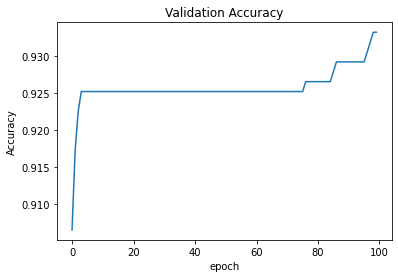

In [188]:
plt.plot(valid_accuracies)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

As the above plot suggests, our model converges to optimal parameters around the 40th epoch. The validation accuracy peaks around ~92.3%.  

## 5. Evaluate the model
Now that we trained our model, it's time to evaluate it using the test dataset, which we did not use when training the model. This gives us a sense of how well our model predicts unseen data, which is the case when we use it in the real world. We will use the `evaluate` method to test the model.

In [189]:
test_loss = 0.0
test_counts = 0

# Setting model to evaluation mode, no parameters will change
model.eval()

for test_features, test_labels in test_dataloader:
    # Calculate Output
    output = model(test_features)

    # Calculate Loss
    loss = criterion(output, test_labels)

    # Saving loss
    test_loss += loss.item()

    # Get Predictions
    test_preds = getPredictions(output)

    # Saving number of right predictions for accuracy
    test_counts += test_preds.eq(test_labels).sum().item()

# Calculating test accuracy
test_acc = test_counts/len(test_dataset)
print('Test Loss: {:.6f} \tTest Accuracy: {:.2f}%'.format(test_loss, test_acc*100))

Test Loss: 0.120642 	Test Accuracy: 94.18%


Wow! Our logistic regression model fit the Google Play Store data pretty well, correctly predicting whether an app was free or not around 93% to 94% of the time. However, the distribution of free apps to non-free apps in our datasets is is not balanced, this is called *class imbalance*. To give our results more context, we should check the *confusion matrix* to make sure the model wasn't just predicting every app as "free" since there are a lot more those than there are "paid" apps.

A confusion matrix indicates the number of correct predictions and incorrect predictions for each class. It is particularly useful whenever the data has an imbalanced representation of the classes. The diagonals of a confusion matrix indicate the correct predictions for each class, while the cross-diagonal indicates misclassified predictions. Below is an example of a binary classification confusion matrix.

<figure>
  <img src='https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png' width='35%'>
  <figcaption>A basic confusion matrix</figcaption>
</figure>

logistic regression model accuracy: 94.18%
confusion matrix:
 [[1758    0]
 [ 109    6]]


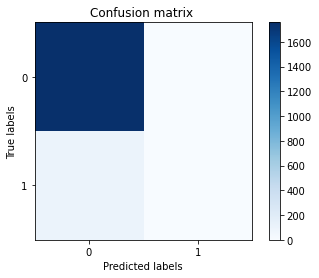

In [190]:
from sklearn import metrics

test_predictions = getPredictions(model(test_features)).numpy()

# Converting labels and predictions to numpy arrays
test_predictions = getPredictions(model(test_features)).numpy()
test_labels = test_labels.numpy()

# measure the accuracy
model_acc = metrics.accuracy_score(test_labels, test_predictions)
print(f'logistic regression model accuracy: {round(model_acc*100, 2)}%')

# plot confusion matrix
labels = ['Free', 'Paid']
cm = metrics.confusion_matrix(test_labels, test_predictions)
print('confusion matrix:\n', cm) 

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0,1])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

From the confusion matrix, we can deduce that the model isn't all that great. In fact, it resorted to predicting every app as free. There are a variety of ways to improve upon this issue, but we won't be covering them in this lesson. Nonetheless, it's important to be aware of misleading model results.

Let's take a look at a more comprehensive set of evaluation metrics: accuracy, precision, and recall. Precision indicates the model's ability to return only relevant instances. While recall indicates the model's ability to identify all relevant instances; and depending on our data we may want a higher precision score or vice versa. If your curious, here is an in-depth discussion about these metrics: [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c). 

In [191]:
print("Accuracy: {}%".format(round(model_acc*100, 2)))
print("Precision:", metrics.precision_score(test_labels, test_predictions, zero_division=True))
print("Recall:" ,metrics.recall_score(test_labels, test_predictions, zero_division=True))

Accuracy: 94.18%
Precision: 1.0
Recall: 0.05217391304347826


What's the take away from all this...

**Always, always contextualize the model's results.**


# Summary

- We use *one-hot encoding* to represent categorical data.
- Logistic regression is popular and foundational algorithm for classification in machine learning and deep learning (neural networks). 
- The *sigmoid* logit function maps the input features to a probability distribution.
- Linear and logistic regression are very similar, they differ in two ways. First, the labels are continous numerical values in linear regression, while they are discrete numerical values (0 and 1) each representing a particular category. Second, logistic regression uses the sigmoid function to transform the input features into a probability space and the model learns the optimal parameters to maximize the probability of confidently predicting the correct class.  